In [1]:
from __future__ import print_function
from __future__ import division

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

import cv2
import numpy as np
import requests
from io import BytesIO
from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Testing**

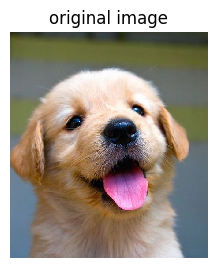

(516, 449, 3)


In [2]:
def error(x, y):
  if type(x) is torch.Tensor:
    x = x.detach().cpu().numpy()
  if type(y) is torch.Tensor:
      y = y.detach().cpu().numpy()    
  return float(np.abs(x - y).max().item())

def display(images, titles=""):
  if type(images) is not list:
    images = [images]
    titles = [titles]
  num = len(images)
  assert len(titles) == num

  plt.figure(figsize=(3*num, 3*num), dpi=100)
  for i in range(num):
    title = titles[i]
    image = images[i]
    plt.subplot(1, num, i+1)
    clip = np.clip(image, 0, 255).astype(np.uint8)
    plt.imshow(clip)
    if len(title) > 0:
      plt.title(title)
    plt.axis('off')
  plt.show()

# read image from url
url = "https://drive.google.com/uc?export=view&id=1IW5HONi0iZoA1gvux_MGXJdnrO8LpJrB"
response = requests.get(url)
rgb_img = Image.open(BytesIO(response.content))
img = np.array(rgb_img).astype("float")
display(img, titles="original image")
print(img.shape)  # H×W×C

**Expected Result from cv2.Laplacian**

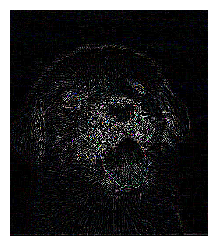

In [3]:
edge = cv2.Laplacian(img.astype(np.uint8), ddepth=24, ksize=1, borderType=cv2.BORDER_CONSTANT)
display(edge * 5)

**Custom Laplacian Filter**

In [4]:
def laplacian_filter(img):
  filtered = None
  laplacian_kernel = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float64).unsqueeze(0).unsqueeze(0)
  channel_array = []
  for channel in range(img.shape[2]):
    img_data = torch.from_numpy(img[:, :, channel].astype(np.float64)).unsqueeze(0).unsqueeze(0)
    after_kernel = F.conv2d(img_data, laplacian_kernel, padding=1).clamp(0., 255.).squeeze(0).squeeze(0)
    channel_array.append(after_kernel.numpy())
  filtered = np.stack(channel_array, axis=-1)
  return filtered

**Check**

In [5]:
def check_laplacian_filter(img):
  x = cv2.Laplacian(img.astype(np.uint8), ddepth=24, ksize=1, borderType=cv2.BORDER_CONSTANT)
  y = laplacian_filter(img)
  err = error(x,y)
  assert err < 1e-5, "large error"
  print("pass")

check_laplacian_filter(img)

pass


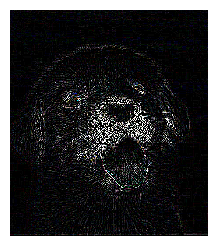

In [6]:
display(laplacian_filter(img)*5)